# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:05<00:00, 11.7KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

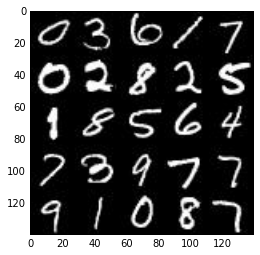

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

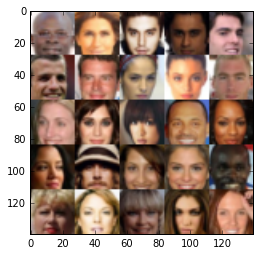

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [78]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [79]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        # x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 16x16x256 now
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        #logits = tf.slice(logits, [0, 2, 2, 0], [-1, 28, 28, -1])
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [80]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [89]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [90]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [94]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.0608... Generator Loss: 3.1503
Epoch 0/2... Discriminator Loss: 0.0979... Generator Loss: 3.4716
Epoch 0/2... Discriminator Loss: 0.0030... Generator Loss: 9.2256
Epoch 0/2... Discriminator Loss: 5.7647... Generator Loss: 0.0048
Epoch 0/2... Discriminator Loss: 0.2171... Generator Loss: 3.2467
Epoch 0/2... Discriminator Loss: 0.8013... Generator Loss: 3.7034
Epoch 0/2... Discriminator Loss: 0.3399... Generator Loss: 2.7230
Epoch 0/2... Discriminator Loss: 0.0268... Generator Loss: 6.7176
Epoch 0/2... Discriminator Loss: 0.8812... Generator Loss: 2.5627


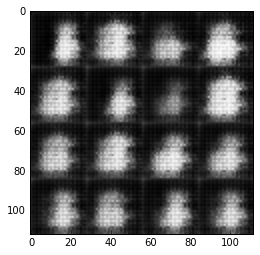

Epoch 0/2... Discriminator Loss: 0.3031... Generator Loss: 3.4149
Epoch 0/2... Discriminator Loss: 0.9019... Generator Loss: 0.6205
Epoch 0/2... Discriminator Loss: 0.3335... Generator Loss: 1.8543
Epoch 0/2... Discriminator Loss: 0.4491... Generator Loss: 1.7703
Epoch 0/2... Discriminator Loss: 0.1433... Generator Loss: 3.0178
Epoch 0/2... Discriminator Loss: 0.0842... Generator Loss: 3.6386
Epoch 0/2... Discriminator Loss: 0.3066... Generator Loss: 2.7727
Epoch 0/2... Discriminator Loss: 0.1537... Generator Loss: 4.8310
Epoch 0/2... Discriminator Loss: 0.3486... Generator Loss: 1.7167
Epoch 0/2... Discriminator Loss: 0.0343... Generator Loss: 4.6618


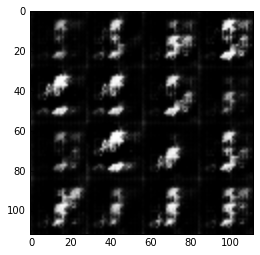

Epoch 0/2... Discriminator Loss: 1.0076... Generator Loss: 9.1079
Epoch 0/2... Discriminator Loss: 0.2767... Generator Loss: 4.4248
Epoch 0/2... Discriminator Loss: 0.1400... Generator Loss: 3.3659
Epoch 0/2... Discriminator Loss: 0.1269... Generator Loss: 3.2889
Epoch 0/2... Discriminator Loss: 0.0839... Generator Loss: 5.6814
Epoch 0/2... Discriminator Loss: 0.2459... Generator Loss: 2.9233
Epoch 0/2... Discriminator Loss: 0.2866... Generator Loss: 4.9421
Epoch 0/2... Discriminator Loss: 0.0688... Generator Loss: 3.9421
Epoch 0/2... Discriminator Loss: 0.0692... Generator Loss: 6.6158
Epoch 0/2... Discriminator Loss: 0.1371... Generator Loss: 3.8557


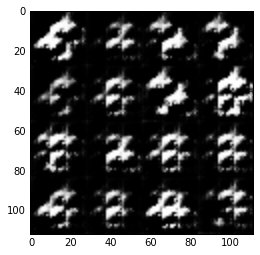

Epoch 0/2... Discriminator Loss: 0.2902... Generator Loss: 9.3342
Epoch 0/2... Discriminator Loss: 0.1365... Generator Loss: 3.0919
Epoch 0/2... Discriminator Loss: 0.2543... Generator Loss: 3.7096
Epoch 0/2... Discriminator Loss: 0.2446... Generator Loss: 3.0415
Epoch 0/2... Discriminator Loss: 0.1877... Generator Loss: 2.4318
Epoch 0/2... Discriminator Loss: 0.1828... Generator Loss: 2.8904
Epoch 0/2... Discriminator Loss: 2.7937... Generator Loss: 11.0747
Epoch 0/2... Discriminator Loss: 0.1638... Generator Loss: 2.6556
Epoch 0/2... Discriminator Loss: 0.1588... Generator Loss: 3.0368
Epoch 0/2... Discriminator Loss: 0.9883... Generator Loss: 0.7067


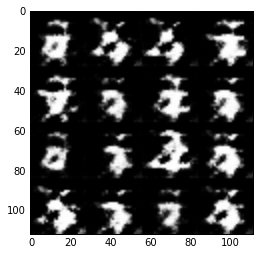

Epoch 0/2... Discriminator Loss: 0.3295... Generator Loss: 2.4852
Epoch 0/2... Discriminator Loss: 0.2234... Generator Loss: 2.7936
Epoch 0/2... Discriminator Loss: 0.1038... Generator Loss: 3.6885
Epoch 0/2... Discriminator Loss: 0.6614... Generator Loss: 1.0463
Epoch 0/2... Discriminator Loss: 0.2077... Generator Loss: 3.0942
Epoch 0/2... Discriminator Loss: 0.4120... Generator Loss: 1.5384
Epoch 0/2... Discriminator Loss: 0.2242... Generator Loss: 2.7151
Epoch 0/2... Discriminator Loss: 0.1506... Generator Loss: 3.3552
Epoch 0/2... Discriminator Loss: 0.2380... Generator Loss: 2.9878
Epoch 0/2... Discriminator Loss: 0.1079... Generator Loss: 3.4102


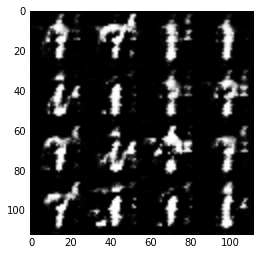

Epoch 0/2... Discriminator Loss: 0.3529... Generator Loss: 1.5792
Epoch 0/2... Discriminator Loss: 0.2684... Generator Loss: 3.4172
Epoch 0/2... Discriminator Loss: 0.2112... Generator Loss: 4.3204
Epoch 0/2... Discriminator Loss: 0.4421... Generator Loss: 2.3349
Epoch 0/2... Discriminator Loss: 0.3436... Generator Loss: 2.1159
Epoch 0/2... Discriminator Loss: 0.1572... Generator Loss: 3.3572
Epoch 0/2... Discriminator Loss: 0.3785... Generator Loss: 3.6073
Epoch 0/2... Discriminator Loss: 0.2154... Generator Loss: 4.2024
Epoch 0/2... Discriminator Loss: 0.2467... Generator Loss: 5.7378
Epoch 0/2... Discriminator Loss: 0.6071... Generator Loss: 1.7398


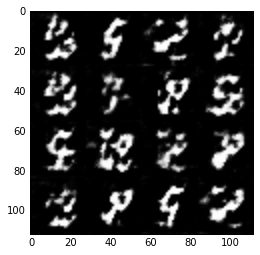

Epoch 0/2... Discriminator Loss: 0.1449... Generator Loss: 2.6788
Epoch 0/2... Discriminator Loss: 0.1759... Generator Loss: 3.2335
Epoch 0/2... Discriminator Loss: 0.4619... Generator Loss: 1.4733
Epoch 0/2... Discriminator Loss: 0.8361... Generator Loss: 5.8598
Epoch 0/2... Discriminator Loss: 0.1973... Generator Loss: 3.2512
Epoch 0/2... Discriminator Loss: 0.4016... Generator Loss: 2.3892
Epoch 0/2... Discriminator Loss: 0.2318... Generator Loss: 2.7721
Epoch 0/2... Discriminator Loss: 0.3038... Generator Loss: 2.6730
Epoch 0/2... Discriminator Loss: 0.5847... Generator Loss: 1.4260
Epoch 0/2... Discriminator Loss: 0.4247... Generator Loss: 1.7036


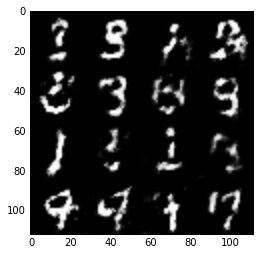

Epoch 0/2... Discriminator Loss: 0.5470... Generator Loss: 1.5805
Epoch 0/2... Discriminator Loss: 0.5785... Generator Loss: 2.9843
Epoch 0/2... Discriminator Loss: 0.5359... Generator Loss: 3.5175
Epoch 0/2... Discriminator Loss: 0.2551... Generator Loss: 2.4220
Epoch 0/2... Discriminator Loss: 0.2674... Generator Loss: 2.4648
Epoch 0/2... Discriminator Loss: 0.6154... Generator Loss: 1.5400
Epoch 0/2... Discriminator Loss: 0.4237... Generator Loss: 1.7063
Epoch 0/2... Discriminator Loss: 0.5761... Generator Loss: 1.3921
Epoch 0/2... Discriminator Loss: 0.6138... Generator Loss: 1.2664
Epoch 0/2... Discriminator Loss: 0.6664... Generator Loss: 2.1740


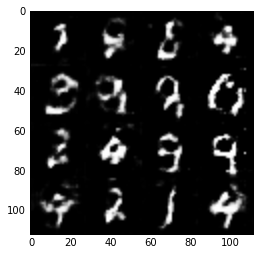

Epoch 0/2... Discriminator Loss: 0.5312... Generator Loss: 1.7956
Epoch 0/2... Discriminator Loss: 1.7098... Generator Loss: 0.4344
Epoch 0/2... Discriminator Loss: 0.7453... Generator Loss: 1.4479
Epoch 0/2... Discriminator Loss: 0.6457... Generator Loss: 1.5881
Epoch 0/2... Discriminator Loss: 0.5869... Generator Loss: 1.5640
Epoch 0/2... Discriminator Loss: 0.9253... Generator Loss: 0.9944
Epoch 0/2... Discriminator Loss: 0.8732... Generator Loss: 0.8791
Epoch 0/2... Discriminator Loss: 0.8276... Generator Loss: 1.2919
Epoch 0/2... Discriminator Loss: 0.5979... Generator Loss: 1.2404
Epoch 0/2... Discriminator Loss: 0.4910... Generator Loss: 1.8017


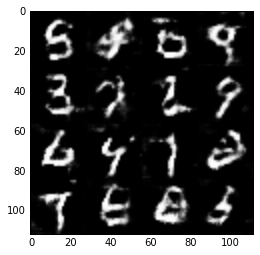

Epoch 0/2... Discriminator Loss: 0.5326... Generator Loss: 1.5621
Epoch 0/2... Discriminator Loss: 0.6537... Generator Loss: 1.5294
Epoch 0/2... Discriminator Loss: 0.8763... Generator Loss: 3.0462
Epoch 0/2... Discriminator Loss: 0.8851... Generator Loss: 0.9349
Epoch 1/2... Discriminator Loss: 0.5522... Generator Loss: 1.4796
Epoch 1/2... Discriminator Loss: 0.6727... Generator Loss: 2.5800
Epoch 1/2... Discriminator Loss: 0.8364... Generator Loss: 0.9108
Epoch 1/2... Discriminator Loss: 0.6133... Generator Loss: 1.5161
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 1.0622
Epoch 1/2... Discriminator Loss: 0.6945... Generator Loss: 1.0245


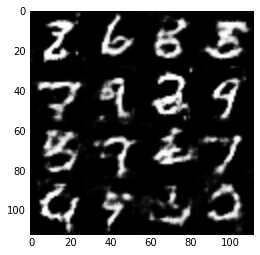

Epoch 1/2... Discriminator Loss: 1.0431... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 1.3486
Epoch 1/2... Discriminator Loss: 0.5609... Generator Loss: 2.1746
Epoch 1/2... Discriminator Loss: 0.7536... Generator Loss: 1.0972
Epoch 1/2... Discriminator Loss: 0.5164... Generator Loss: 1.5998
Epoch 1/2... Discriminator Loss: 0.6433... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 0.5461... Generator Loss: 1.2663
Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 0.5017
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.0457
Epoch 1/2... Discriminator Loss: 0.6703... Generator Loss: 1.4879


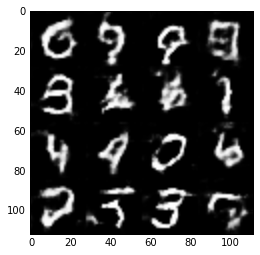

Epoch 1/2... Discriminator Loss: 0.8695... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 0.8634
Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 3.1573
Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 0.9955
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.4264
Epoch 1/2... Discriminator Loss: 0.8941... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 3.1611
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 1.3248
Epoch 1/2... Discriminator Loss: 0.5441... Generator Loss: 1.4905
Epoch 1/2... Discriminator Loss: 0.6691... Generator Loss: 1.4513


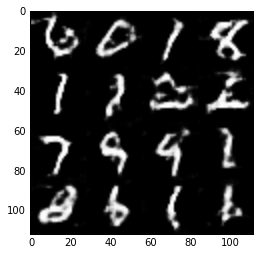

Epoch 1/2... Discriminator Loss: 0.7822... Generator Loss: 2.0697
Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 0.9666
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.6183
Epoch 1/2... Discriminator Loss: 0.6611... Generator Loss: 1.8420
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 0.8735
Epoch 1/2... Discriminator Loss: 0.7634... Generator Loss: 0.8828
Epoch 1/2... Discriminator Loss: 0.8434... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 0.5453... Generator Loss: 1.7804
Epoch 1/2... Discriminator Loss: 0.7839... Generator Loss: 2.9623
Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 2.3269


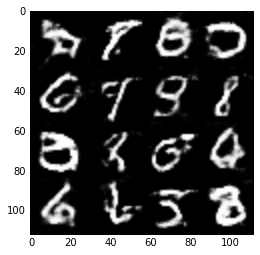

Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 0.8212
Epoch 1/2... Discriminator Loss: 0.7161... Generator Loss: 1.1612
Epoch 1/2... Discriminator Loss: 0.5792... Generator Loss: 1.3504
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 3.2996
Epoch 1/2... Discriminator Loss: 0.7251... Generator Loss: 1.0464
Epoch 1/2... Discriminator Loss: 0.7504... Generator Loss: 2.1574
Epoch 1/2... Discriminator Loss: 0.5279... Generator Loss: 1.7473
Epoch 1/2... Discriminator Loss: 0.7654... Generator Loss: 0.8944
Epoch 1/2... Discriminator Loss: 0.4897... Generator Loss: 1.9568
Epoch 1/2... Discriminator Loss: 0.5536... Generator Loss: 1.6944


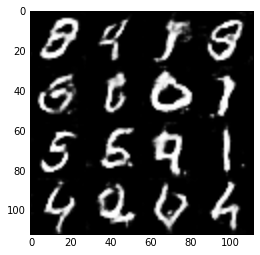

Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 0.8376... Generator Loss: 1.0163
Epoch 1/2... Discriminator Loss: 0.6193... Generator Loss: 1.6970
Epoch 1/2... Discriminator Loss: 0.4669... Generator Loss: 1.9307
Epoch 1/2... Discriminator Loss: 0.6910... Generator Loss: 1.3747
Epoch 1/2... Discriminator Loss: 0.5845... Generator Loss: 1.7130
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 2.1819
Epoch 1/2... Discriminator Loss: 0.8367... Generator Loss: 1.0741
Epoch 1/2... Discriminator Loss: 0.8230... Generator Loss: 0.9006
Epoch 1/2... Discriminator Loss: 0.7305... Generator Loss: 0.9622


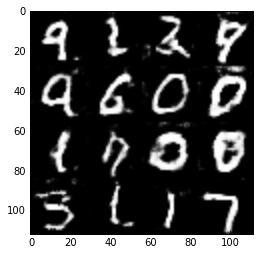

Epoch 1/2... Discriminator Loss: 0.6782... Generator Loss: 1.2938
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 1.1441... Generator Loss: 0.5207
Epoch 1/2... Discriminator Loss: 4.9941... Generator Loss: 0.0132
Epoch 1/2... Discriminator Loss: 0.6395... Generator Loss: 1.2665
Epoch 1/2... Discriminator Loss: 0.6191... Generator Loss: 1.1154
Epoch 1/2... Discriminator Loss: 0.7605... Generator Loss: 0.9378
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 0.5055
Epoch 1/2... Discriminator Loss: 0.8832... Generator Loss: 0.7921
Epoch 1/2... Discriminator Loss: 2.2434... Generator Loss: 3.7821


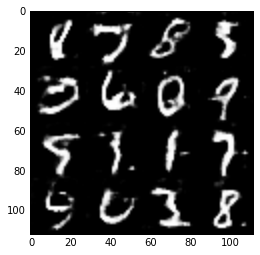

Epoch 1/2... Discriminator Loss: 0.4697... Generator Loss: 1.5708
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 0.8345
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 0.4912
Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 0.4233
Epoch 1/2... Discriminator Loss: 0.8711... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 0.8710... Generator Loss: 0.7440
Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 0.4144
Epoch 1/2... Discriminator Loss: 0.9079... Generator Loss: 1.1999
Epoch 1/2... Discriminator Loss: 0.8959... Generator Loss: 1.7709


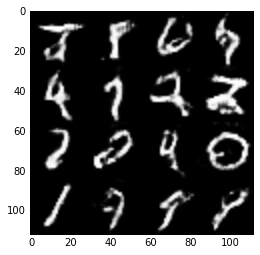

Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 2.0807
Epoch 1/2... Discriminator Loss: 0.5627... Generator Loss: 1.3682
Epoch 1/2... Discriminator Loss: 0.8060... Generator Loss: 1.1426
Epoch 1/2... Discriminator Loss: 1.0218... Generator Loss: 0.6246
Epoch 1/2... Discriminator Loss: 0.8582... Generator Loss: 0.9117
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 1.4719
Epoch 1/2... Discriminator Loss: 0.8058... Generator Loss: 0.8663
Epoch 1/2... Discriminator Loss: 0.9832... Generator Loss: 0.7069
Epoch 1/2... Discriminator Loss: 0.9853... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.0496... Generator Loss: 0.6071


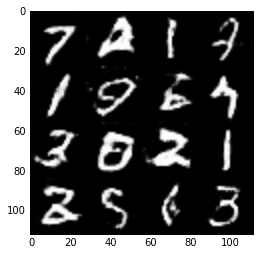

Epoch 1/2... Discriminator Loss: 0.5197... Generator Loss: 1.3683
Epoch 1/2... Discriminator Loss: 1.2006... Generator Loss: 0.4961
Epoch 1/2... Discriminator Loss: 5.4587... Generator Loss: 7.8316
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 0.8810
Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 0.7867
Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 0.7144
Epoch 1/2... Discriminator Loss: 0.6788... Generator Loss: 1.1249
Epoch 1/2... Discriminator Loss: 0.8901... Generator Loss: 0.8351


In [92]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.2522... Generator Loss: 5.0123
Epoch 0/1... Discriminator Loss: 0.3488... Generator Loss: 11.6846
Epoch 0/1... Discriminator Loss: 0.4080... Generator Loss: 16.8401
Epoch 0/1... Discriminator Loss: 0.0823... Generator Loss: 9.7562


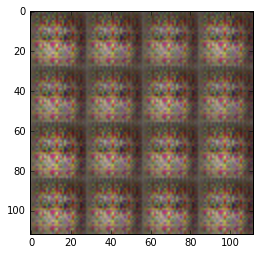

Epoch 0/1... Discriminator Loss: 0.4776... Generator Loss: 9.6113
Epoch 0/1... Discriminator Loss: 0.5488... Generator Loss: 1.1174
Epoch 0/1... Discriminator Loss: 0.4828... Generator Loss: 8.1731
Epoch 0/1... Discriminator Loss: 0.7211... Generator Loss: 1.1925
Epoch 0/1... Discriminator Loss: 0.1920... Generator Loss: 4.3797


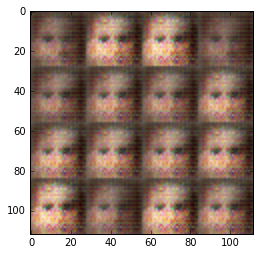

Epoch 0/1... Discriminator Loss: 0.1972... Generator Loss: 2.8847
Epoch 0/1... Discriminator Loss: 0.8683... Generator Loss: 0.7069
Epoch 0/1... Discriminator Loss: 0.3377... Generator Loss: 1.5301
Epoch 0/1... Discriminator Loss: 0.6705... Generator Loss: 0.9990
Epoch 0/1... Discriminator Loss: 0.3622... Generator Loss: 2.6939


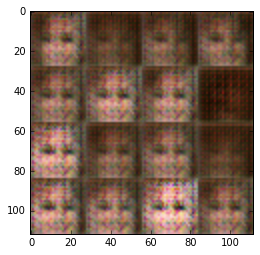

Epoch 0/1... Discriminator Loss: 0.4249... Generator Loss: 1.3853
Epoch 0/1... Discriminator Loss: 0.8248... Generator Loss: 6.1613
Epoch 0/1... Discriminator Loss: 0.3771... Generator Loss: 3.3562
Epoch 0/1... Discriminator Loss: 0.6689... Generator Loss: 1.0574
Epoch 0/1... Discriminator Loss: 0.4798... Generator Loss: 3.4276


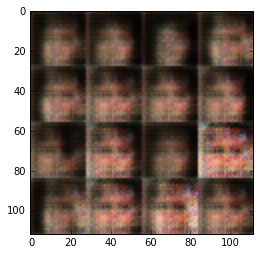

Epoch 0/1... Discriminator Loss: 0.6299... Generator Loss: 1.4585
Epoch 0/1... Discriminator Loss: 0.8017... Generator Loss: 2.2742
Epoch 0/1... Discriminator Loss: 1.1189... Generator Loss: 2.1559
Epoch 0/1... Discriminator Loss: 0.8748... Generator Loss: 2.1381
Epoch 0/1... Discriminator Loss: 1.4240... Generator Loss: 0.9585


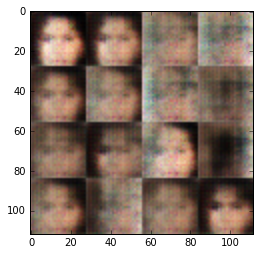

Epoch 0/1... Discriminator Loss: 1.3499... Generator Loss: 1.0607
Epoch 0/1... Discriminator Loss: 1.2513... Generator Loss: 0.9113
Epoch 0/1... Discriminator Loss: 0.8309... Generator Loss: 1.2337
Epoch 0/1... Discriminator Loss: 1.0564... Generator Loss: 2.4216
Epoch 0/1... Discriminator Loss: 0.7526... Generator Loss: 1.6533


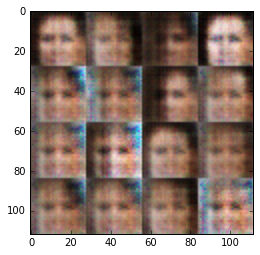

Epoch 0/1... Discriminator Loss: 1.2834... Generator Loss: 0.6975
Epoch 0/1... Discriminator Loss: 0.9442... Generator Loss: 1.2242
Epoch 0/1... Discriminator Loss: 0.9482... Generator Loss: 2.1419
Epoch 0/1... Discriminator Loss: 0.9349... Generator Loss: 0.9724
Epoch 0/1... Discriminator Loss: 1.0497... Generator Loss: 2.1535


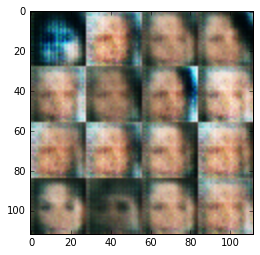

Epoch 0/1... Discriminator Loss: 1.0054... Generator Loss: 1.5846
Epoch 0/1... Discriminator Loss: 1.2442... Generator Loss: 0.8978
Epoch 0/1... Discriminator Loss: 1.3502... Generator Loss: 0.6682
Epoch 0/1... Discriminator Loss: 0.9536... Generator Loss: 0.9938
Epoch 0/1... Discriminator Loss: 0.8018... Generator Loss: 1.7917


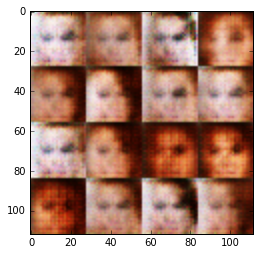

Epoch 0/1... Discriminator Loss: 0.7259... Generator Loss: 1.5899
Epoch 0/1... Discriminator Loss: 1.0290... Generator Loss: 1.1469
Epoch 0/1... Discriminator Loss: 0.4792... Generator Loss: 1.8486
Epoch 0/1... Discriminator Loss: 0.9077... Generator Loss: 0.9153
Epoch 0/1... Discriminator Loss: 1.0225... Generator Loss: 0.9200


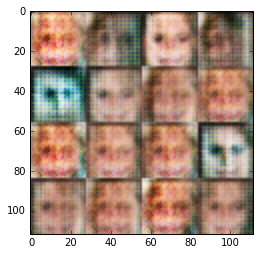

Epoch 0/1... Discriminator Loss: 0.3963... Generator Loss: 2.6242
Epoch 0/1... Discriminator Loss: 1.0757... Generator Loss: 0.6234
Epoch 0/1... Discriminator Loss: 0.6764... Generator Loss: 1.3440
Epoch 0/1... Discriminator Loss: 0.8170... Generator Loss: 1.1796
Epoch 0/1... Discriminator Loss: 1.2234... Generator Loss: 0.6812


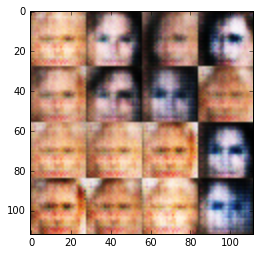

Epoch 0/1... Discriminator Loss: 0.8374... Generator Loss: 0.9719
Epoch 0/1... Discriminator Loss: 1.1284... Generator Loss: 0.5523
Epoch 0/1... Discriminator Loss: 0.6283... Generator Loss: 1.4959
Epoch 0/1... Discriminator Loss: 0.7716... Generator Loss: 1.2422
Epoch 0/1... Discriminator Loss: 0.6769... Generator Loss: 1.6500


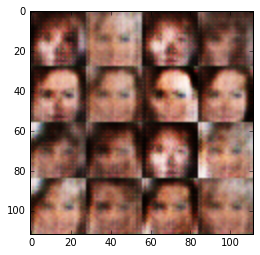

Epoch 0/1... Discriminator Loss: 0.7526... Generator Loss: 1.2742
Epoch 0/1... Discriminator Loss: 0.7316... Generator Loss: 1.6183
Epoch 0/1... Discriminator Loss: 1.0197... Generator Loss: 1.4828
Epoch 0/1... Discriminator Loss: 1.0349... Generator Loss: 2.0611
Epoch 0/1... Discriminator Loss: 0.8069... Generator Loss: 1.3345


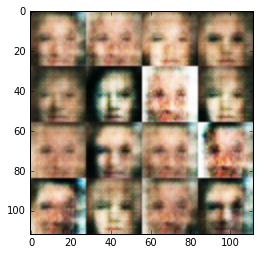

Epoch 0/1... Discriminator Loss: 0.9074... Generator Loss: 1.2228
Epoch 0/1... Discriminator Loss: 0.7134... Generator Loss: 2.0943
Epoch 0/1... Discriminator Loss: 0.8954... Generator Loss: 1.8795
Epoch 0/1... Discriminator Loss: 0.8788... Generator Loss: 1.0659
Epoch 0/1... Discriminator Loss: 0.6754... Generator Loss: 1.4731


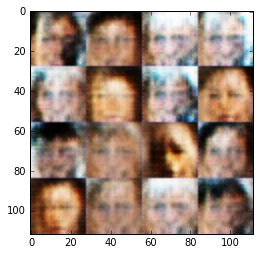

Epoch 0/1... Discriminator Loss: 1.0066... Generator Loss: 1.2840
Epoch 0/1... Discriminator Loss: 1.1507... Generator Loss: 0.6983
Epoch 0/1... Discriminator Loss: 1.1810... Generator Loss: 0.6262
Epoch 0/1... Discriminator Loss: 1.2379... Generator Loss: 0.5852
Epoch 0/1... Discriminator Loss: 0.9061... Generator Loss: 0.8947


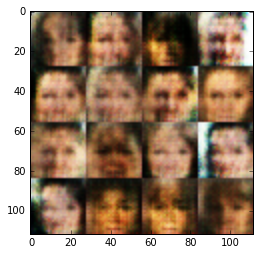

Epoch 0/1... Discriminator Loss: 1.0475... Generator Loss: 1.2416
Epoch 0/1... Discriminator Loss: 0.8089... Generator Loss: 1.3006
Epoch 0/1... Discriminator Loss: 1.2742... Generator Loss: 0.6949
Epoch 0/1... Discriminator Loss: 0.8404... Generator Loss: 1.4105
Epoch 0/1... Discriminator Loss: 0.7557... Generator Loss: 2.2205


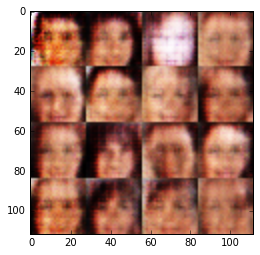

Epoch 0/1... Discriminator Loss: 1.6155... Generator Loss: 0.3732
Epoch 0/1... Discriminator Loss: 1.1334... Generator Loss: 0.6489
Epoch 0/1... Discriminator Loss: 0.9138... Generator Loss: 1.2260
Epoch 0/1... Discriminator Loss: 1.0591... Generator Loss: 0.7089
Epoch 0/1... Discriminator Loss: 1.1968... Generator Loss: 0.6255


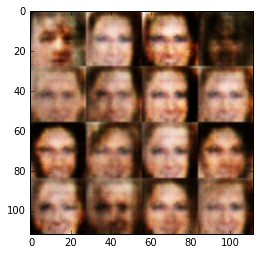

Epoch 0/1... Discriminator Loss: 1.6451... Generator Loss: 0.3316
Epoch 0/1... Discriminator Loss: 0.7319... Generator Loss: 1.3541
Epoch 0/1... Discriminator Loss: 1.1937... Generator Loss: 1.3411
Epoch 0/1... Discriminator Loss: 1.1394... Generator Loss: 0.7490
Epoch 0/1... Discriminator Loss: 0.6761... Generator Loss: 1.6164


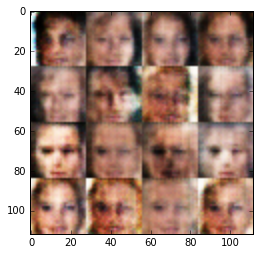

Epoch 0/1... Discriminator Loss: 1.4446... Generator Loss: 1.0380
Epoch 0/1... Discriminator Loss: 1.0213... Generator Loss: 1.2169
Epoch 0/1... Discriminator Loss: 1.2266... Generator Loss: 0.6910
Epoch 0/1... Discriminator Loss: 1.2278... Generator Loss: 1.4181
Epoch 0/1... Discriminator Loss: 1.1455... Generator Loss: 1.2271


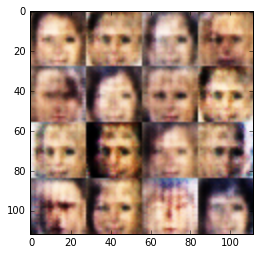

Epoch 0/1... Discriminator Loss: 1.2076... Generator Loss: 0.8779
Epoch 0/1... Discriminator Loss: 1.1961... Generator Loss: 0.7185
Epoch 0/1... Discriminator Loss: 1.0819... Generator Loss: 1.7792
Epoch 0/1... Discriminator Loss: 1.2597... Generator Loss: 0.4859
Epoch 0/1... Discriminator Loss: 1.1590... Generator Loss: 1.4639


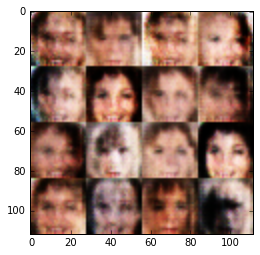

Epoch 0/1... Discriminator Loss: 1.5180... Generator Loss: 0.3742
Epoch 0/1... Discriminator Loss: 1.3187... Generator Loss: 1.6543
Epoch 0/1... Discriminator Loss: 0.8149... Generator Loss: 1.1505
Epoch 0/1... Discriminator Loss: 1.0599... Generator Loss: 0.7349
Epoch 0/1... Discriminator Loss: 0.9397... Generator Loss: 1.0582


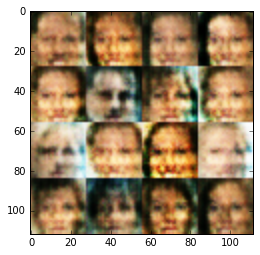

Epoch 0/1... Discriminator Loss: 0.8779... Generator Loss: 1.3606
Epoch 0/1... Discriminator Loss: 0.9419... Generator Loss: 1.1650
Epoch 0/1... Discriminator Loss: 1.2050... Generator Loss: 0.5754
Epoch 0/1... Discriminator Loss: 1.0805... Generator Loss: 0.9705
Epoch 0/1... Discriminator Loss: 1.1167... Generator Loss: 0.9360


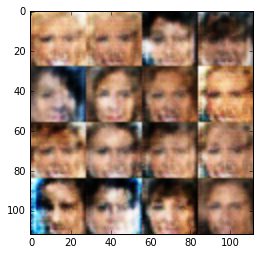

Epoch 0/1... Discriminator Loss: 1.1929... Generator Loss: 1.8130
Epoch 0/1... Discriminator Loss: 1.1333... Generator Loss: 1.0017
Epoch 0/1... Discriminator Loss: 1.0097... Generator Loss: 0.9539
Epoch 0/1... Discriminator Loss: 1.2177... Generator Loss: 1.1433
Epoch 0/1... Discriminator Loss: 1.0050... Generator Loss: 1.8421


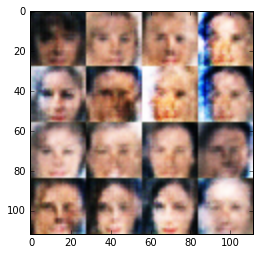

Epoch 0/1... Discriminator Loss: 0.6939... Generator Loss: 1.2901
Epoch 0/1... Discriminator Loss: 0.9810... Generator Loss: 0.8616
Epoch 0/1... Discriminator Loss: 0.9037... Generator Loss: 1.0971
Epoch 0/1... Discriminator Loss: 1.2353... Generator Loss: 1.3959
Epoch 0/1... Discriminator Loss: 1.3894... Generator Loss: 2.4853


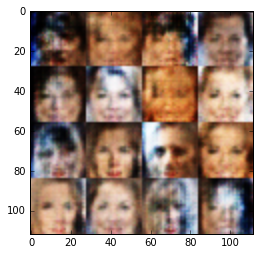

Epoch 0/1... Discriminator Loss: 1.1483... Generator Loss: 1.0863
Epoch 0/1... Discriminator Loss: 1.1033... Generator Loss: 0.9450
Epoch 0/1... Discriminator Loss: 1.0540... Generator Loss: 0.8906
Epoch 0/1... Discriminator Loss: 1.2326... Generator Loss: 0.7640
Epoch 0/1... Discriminator Loss: 0.9133... Generator Loss: 1.1645


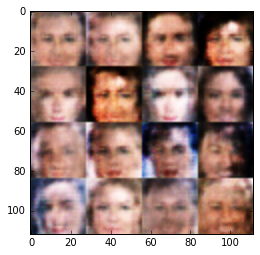

Epoch 0/1... Discriminator Loss: 1.0140... Generator Loss: 1.0102
Epoch 0/1... Discriminator Loss: 1.4651... Generator Loss: 0.4206
Epoch 0/1... Discriminator Loss: 1.1938... Generator Loss: 1.9453
Epoch 0/1... Discriminator Loss: 0.9737... Generator Loss: 1.1930
Epoch 0/1... Discriminator Loss: 1.4641... Generator Loss: 2.6076


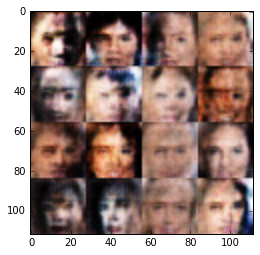

Epoch 0/1... Discriminator Loss: 0.9192... Generator Loss: 1.2392
Epoch 0/1... Discriminator Loss: 0.8013... Generator Loss: 0.9390
Epoch 0/1... Discriminator Loss: 0.9424... Generator Loss: 1.0154
Epoch 0/1... Discriminator Loss: 0.9962... Generator Loss: 0.9315
Epoch 0/1... Discriminator Loss: 0.9385... Generator Loss: 0.9960


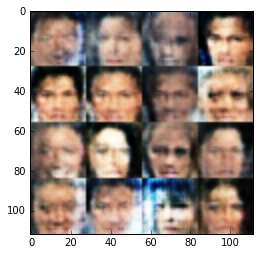

Epoch 0/1... Discriminator Loss: 0.8924... Generator Loss: 1.2897
Epoch 0/1... Discriminator Loss: 0.9823... Generator Loss: 1.8975
Epoch 0/1... Discriminator Loss: 1.1504... Generator Loss: 0.5854
Epoch 0/1... Discriminator Loss: 1.0369... Generator Loss: 1.1206
Epoch 0/1... Discriminator Loss: 1.0213... Generator Loss: 0.9608


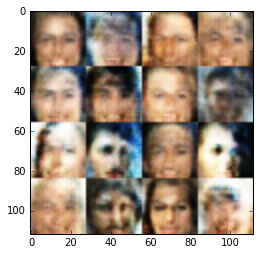

Epoch 0/1... Discriminator Loss: 0.9684... Generator Loss: 0.9002
Epoch 0/1... Discriminator Loss: 0.8057... Generator Loss: 1.0830
Epoch 0/1... Discriminator Loss: 0.8650... Generator Loss: 1.3062
Epoch 0/1... Discriminator Loss: 1.2120... Generator Loss: 0.6145
Epoch 0/1... Discriminator Loss: 1.4616... Generator Loss: 0.5646


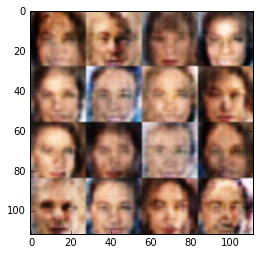

Epoch 0/1... Discriminator Loss: 1.0196... Generator Loss: 1.5462
Epoch 0/1... Discriminator Loss: 1.0566... Generator Loss: 0.6530
Epoch 0/1... Discriminator Loss: 0.8383... Generator Loss: 1.2357
Epoch 0/1... Discriminator Loss: 0.8767... Generator Loss: 1.5723
Epoch 0/1... Discriminator Loss: 1.2789... Generator Loss: 0.9514


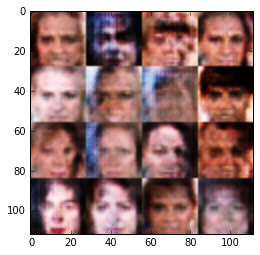

Epoch 0/1... Discriminator Loss: 0.9730... Generator Loss: 1.0362
Epoch 0/1... Discriminator Loss: 1.2661... Generator Loss: 0.5610
Epoch 0/1... Discriminator Loss: 0.8702... Generator Loss: 1.0389
Epoch 0/1... Discriminator Loss: 1.0586... Generator Loss: 0.9914
Epoch 0/1... Discriminator Loss: 0.9882... Generator Loss: 2.0487


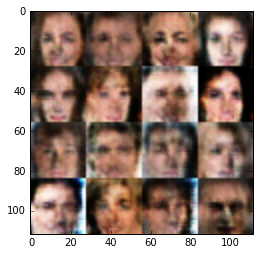

Epoch 0/1... Discriminator Loss: 0.8793... Generator Loss: 1.3412
Epoch 0/1... Discriminator Loss: 1.1422... Generator Loss: 0.6682
Epoch 0/1... Discriminator Loss: 1.0049... Generator Loss: 1.0542
Epoch 0/1... Discriminator Loss: 1.5172... Generator Loss: 2.5899
Epoch 0/1... Discriminator Loss: 1.4219... Generator Loss: 0.9645


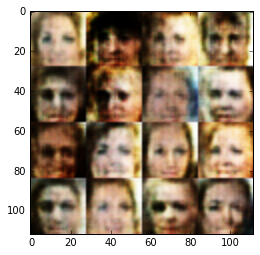

Epoch 0/1... Discriminator Loss: 1.4651... Generator Loss: 0.4360
Epoch 0/1... Discriminator Loss: 1.1399... Generator Loss: 0.8978
Epoch 0/1... Discriminator Loss: 0.9169... Generator Loss: 1.1139
Epoch 0/1... Discriminator Loss: 1.1528... Generator Loss: 0.6062
Epoch 0/1... Discriminator Loss: 1.0128... Generator Loss: 1.1103


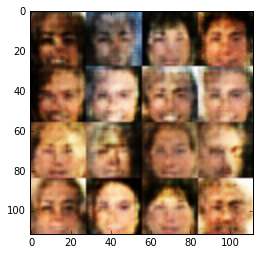

Epoch 0/1... Discriminator Loss: 1.3429... Generator Loss: 0.5516
Epoch 0/1... Discriminator Loss: 1.1570... Generator Loss: 1.2646
Epoch 0/1... Discriminator Loss: 1.1900... Generator Loss: 0.8483
Epoch 0/1... Discriminator Loss: 1.6023... Generator Loss: 0.3354
Epoch 0/1... Discriminator Loss: 1.1365... Generator Loss: 0.6784


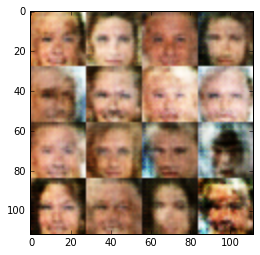

Epoch 0/1... Discriminator Loss: 0.8767... Generator Loss: 1.3273
Epoch 0/1... Discriminator Loss: 0.8780... Generator Loss: 1.0594
Epoch 0/1... Discriminator Loss: 1.0645... Generator Loss: 1.5372
Epoch 0/1... Discriminator Loss: 1.0428... Generator Loss: 0.8061
Epoch 0/1... Discriminator Loss: 0.9699... Generator Loss: 1.0668


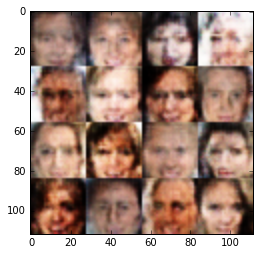

Epoch 0/1... Discriminator Loss: 0.9542... Generator Loss: 1.3103
Epoch 0/1... Discriminator Loss: 1.5000... Generator Loss: 0.3706
Epoch 0/1... Discriminator Loss: 0.9056... Generator Loss: 0.9624
Epoch 0/1... Discriminator Loss: 1.2206... Generator Loss: 0.6625
Epoch 0/1... Discriminator Loss: 0.9998... Generator Loss: 1.0791


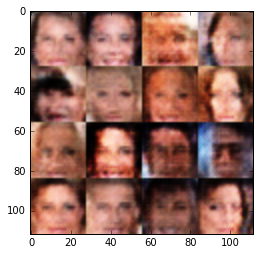

Epoch 0/1... Discriminator Loss: 0.8678... Generator Loss: 2.6254
Epoch 0/1... Discriminator Loss: 1.0891... Generator Loss: 0.7813
Epoch 0/1... Discriminator Loss: 1.2657... Generator Loss: 0.5366
Epoch 0/1... Discriminator Loss: 0.9795... Generator Loss: 1.0604
Epoch 0/1... Discriminator Loss: 0.9247... Generator Loss: 1.4768


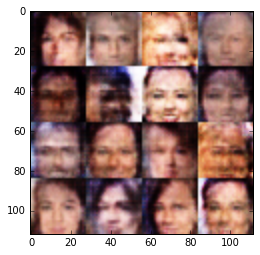

Epoch 0/1... Discriminator Loss: 1.0519... Generator Loss: 0.8147
Epoch 0/1... Discriminator Loss: 1.1806... Generator Loss: 0.9416
Epoch 0/1... Discriminator Loss: 1.1495... Generator Loss: 1.4087
Epoch 0/1... Discriminator Loss: 0.9930... Generator Loss: 0.8654
Epoch 0/1... Discriminator Loss: 1.6274... Generator Loss: 0.3486


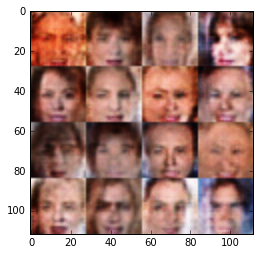

Epoch 0/1... Discriminator Loss: 0.8716... Generator Loss: 1.3685
Epoch 0/1... Discriminator Loss: 0.9621... Generator Loss: 1.1524
Epoch 0/1... Discriminator Loss: 0.8822... Generator Loss: 1.4315
Epoch 0/1... Discriminator Loss: 1.0692... Generator Loss: 1.0001
Epoch 0/1... Discriminator Loss: 0.9244... Generator Loss: 0.7641


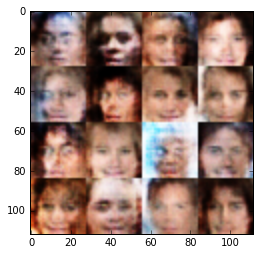

Epoch 0/1... Discriminator Loss: 1.3150... Generator Loss: 0.4599
Epoch 0/1... Discriminator Loss: 0.9715... Generator Loss: 1.8010
Epoch 0/1... Discriminator Loss: 0.9578... Generator Loss: 0.9497
Epoch 0/1... Discriminator Loss: 1.1188... Generator Loss: 0.6597
Epoch 0/1... Discriminator Loss: 0.8927... Generator Loss: 0.9812


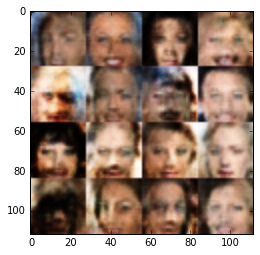

Epoch 0/1... Discriminator Loss: 0.7875... Generator Loss: 0.9912
Epoch 0/1... Discriminator Loss: 0.7933... Generator Loss: 1.1254
Epoch 0/1... Discriminator Loss: 1.5258... Generator Loss: 0.5480
Epoch 0/1... Discriminator Loss: 1.2913... Generator Loss: 0.5897
Epoch 0/1... Discriminator Loss: 1.0879... Generator Loss: 0.6553


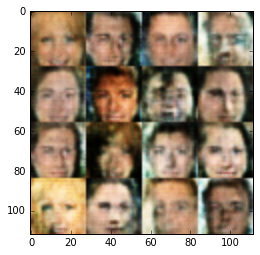

Epoch 0/1... Discriminator Loss: 1.0647... Generator Loss: 0.9764
Epoch 0/1... Discriminator Loss: 1.0331... Generator Loss: 1.0458
Epoch 0/1... Discriminator Loss: 1.0137... Generator Loss: 0.8374
Epoch 0/1... Discriminator Loss: 0.8331... Generator Loss: 0.9949
Epoch 0/1... Discriminator Loss: 0.9050... Generator Loss: 0.8753


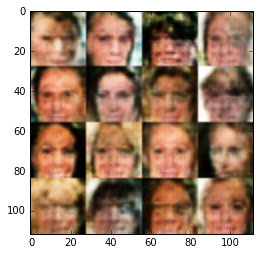

Epoch 0/1... Discriminator Loss: 1.1550... Generator Loss: 0.9481
Epoch 0/1... Discriminator Loss: 1.0483... Generator Loss: 1.0888
Epoch 0/1... Discriminator Loss: 0.7697... Generator Loss: 1.1867
Epoch 0/1... Discriminator Loss: 1.0740... Generator Loss: 0.6541
Epoch 0/1... Discriminator Loss: 1.0400... Generator Loss: 1.2128


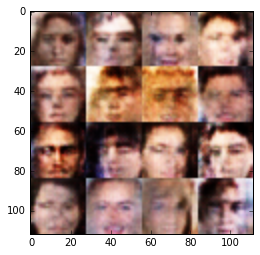

Epoch 0/1... Discriminator Loss: 1.0856... Generator Loss: 1.0192
Epoch 0/1... Discriminator Loss: 0.9095... Generator Loss: 1.3838
Epoch 0/1... Discriminator Loss: 1.0597... Generator Loss: 1.9302
Epoch 0/1... Discriminator Loss: 1.3324... Generator Loss: 2.1278
Epoch 0/1... Discriminator Loss: 1.4585... Generator Loss: 0.4439


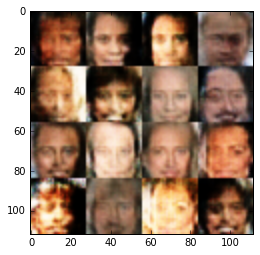

Epoch 0/1... Discriminator Loss: 0.9276... Generator Loss: 1.3421
Epoch 0/1... Discriminator Loss: 1.2631... Generator Loss: 0.5019
Epoch 0/1... Discriminator Loss: 1.0644... Generator Loss: 0.6224
Epoch 0/1... Discriminator Loss: 1.6269... Generator Loss: 0.3203
Epoch 0/1... Discriminator Loss: 1.1156... Generator Loss: 0.5705


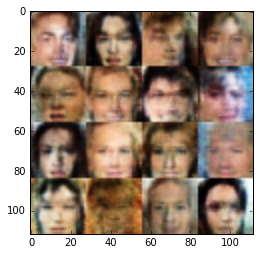

Epoch 0/1... Discriminator Loss: 0.9743... Generator Loss: 1.0155
Epoch 0/1... Discriminator Loss: 1.0269... Generator Loss: 0.6713
Epoch 0/1... Discriminator Loss: 0.6895... Generator Loss: 1.9121
Epoch 0/1... Discriminator Loss: 0.8812... Generator Loss: 1.5434
Epoch 0/1... Discriminator Loss: 1.0099... Generator Loss: 0.8648


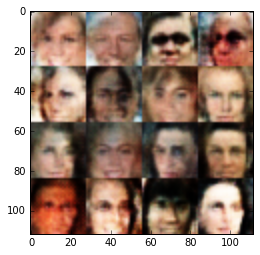

Epoch 0/1... Discriminator Loss: 1.0315... Generator Loss: 0.8195
Epoch 0/1... Discriminator Loss: 0.7802... Generator Loss: 1.2047
Epoch 0/1... Discriminator Loss: 1.2796... Generator Loss: 1.8004
Epoch 0/1... Discriminator Loss: 0.9996... Generator Loss: 1.0902
Epoch 0/1... Discriminator Loss: 1.1371... Generator Loss: 0.6446


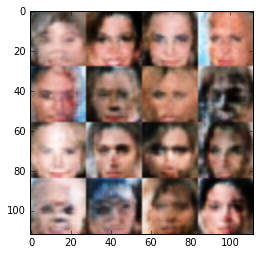

Epoch 0/1... Discriminator Loss: 0.9457... Generator Loss: 0.9379
Epoch 0/1... Discriminator Loss: 1.3148... Generator Loss: 0.5363
Epoch 0/1... Discriminator Loss: 1.0098... Generator Loss: 1.4329
Epoch 0/1... Discriminator Loss: 0.8445... Generator Loss: 1.5770
Epoch 0/1... Discriminator Loss: 1.4004... Generator Loss: 0.4339


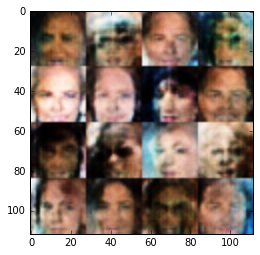

Epoch 0/1... Discriminator Loss: 0.8630... Generator Loss: 1.8946
Epoch 0/1... Discriminator Loss: 1.1177... Generator Loss: 1.5526
Epoch 0/1... Discriminator Loss: 0.9356... Generator Loss: 0.8881
Epoch 0/1... Discriminator Loss: 0.9881... Generator Loss: 1.3126
Epoch 0/1... Discriminator Loss: 1.2636... Generator Loss: 2.4016


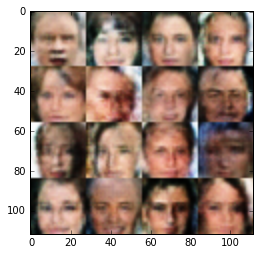

Epoch 0/1... Discriminator Loss: 0.6903... Generator Loss: 1.2978
Epoch 0/1... Discriminator Loss: 0.9933... Generator Loss: 1.3347
Epoch 0/1... Discriminator Loss: 0.8044... Generator Loss: 1.1701
Epoch 0/1... Discriminator Loss: 0.9131... Generator Loss: 0.8363
Epoch 0/1... Discriminator Loss: 1.1998... Generator Loss: 1.7252


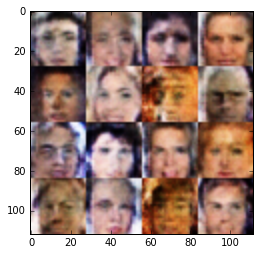

Epoch 0/1... Discriminator Loss: 1.1373... Generator Loss: 0.8867
Epoch 0/1... Discriminator Loss: 1.5231... Generator Loss: 0.3855
Epoch 0/1... Discriminator Loss: 0.7248... Generator Loss: 1.4435
Epoch 0/1... Discriminator Loss: 1.1523... Generator Loss: 2.2402
Epoch 0/1... Discriminator Loss: 1.0252... Generator Loss: 0.7206


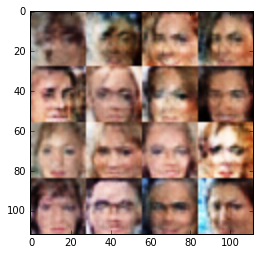

Epoch 0/1... Discriminator Loss: 1.3822... Generator Loss: 0.4157
Epoch 0/1... Discriminator Loss: 1.0607... Generator Loss: 1.1384
Epoch 0/1... Discriminator Loss: 0.9204... Generator Loss: 1.5917
Epoch 0/1... Discriminator Loss: 1.1051... Generator Loss: 0.7047
Epoch 0/1... Discriminator Loss: 0.9659... Generator Loss: 0.7505


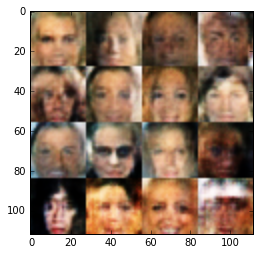

Epoch 0/1... Discriminator Loss: 1.0629... Generator Loss: 0.8075
Epoch 0/1... Discriminator Loss: 0.8699... Generator Loss: 1.4608
Epoch 0/1... Discriminator Loss: 1.0377... Generator Loss: 0.9595
Epoch 0/1... Discriminator Loss: 1.1432... Generator Loss: 0.6052
Epoch 0/1... Discriminator Loss: 1.0944... Generator Loss: 1.1414


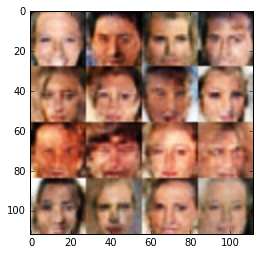

Epoch 0/1... Discriminator Loss: 1.4424... Generator Loss: 0.3770
Epoch 0/1... Discriminator Loss: 0.9440... Generator Loss: 0.7932
Epoch 0/1... Discriminator Loss: 0.9452... Generator Loss: 1.3616
Epoch 0/1... Discriminator Loss: 1.0706... Generator Loss: 0.7110
Epoch 0/1... Discriminator Loss: 0.9667... Generator Loss: 1.1239


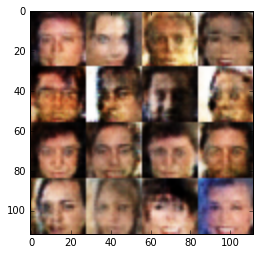

Epoch 0/1... Discriminator Loss: 0.9602... Generator Loss: 1.2727
Epoch 0/1... Discriminator Loss: 1.1721... Generator Loss: 1.2621
Epoch 0/1... Discriminator Loss: 0.9449... Generator Loss: 0.9131
Epoch 0/1... Discriminator Loss: 1.0470... Generator Loss: 1.2072
Epoch 0/1... Discriminator Loss: 1.0900... Generator Loss: 0.6593


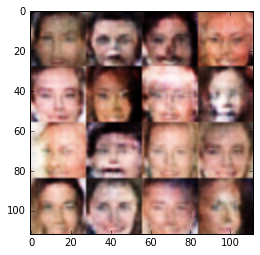

Epoch 0/1... Discriminator Loss: 0.7803... Generator Loss: 1.1657
Epoch 0/1... Discriminator Loss: 0.9989... Generator Loss: 0.7603
Epoch 0/1... Discriminator Loss: 0.8593... Generator Loss: 1.4841
Epoch 0/1... Discriminator Loss: 1.4575... Generator Loss: 0.3858
Epoch 0/1... Discriminator Loss: 1.2479... Generator Loss: 1.3987


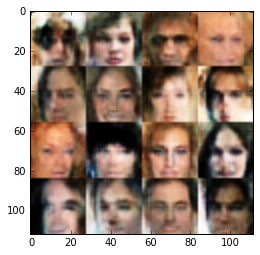

Epoch 0/1... Discriminator Loss: 0.9918... Generator Loss: 0.9777
Epoch 0/1... Discriminator Loss: 1.0992... Generator Loss: 0.7948
Epoch 0/1... Discriminator Loss: 1.2855... Generator Loss: 0.5378
Epoch 0/1... Discriminator Loss: 0.9338... Generator Loss: 0.9522
Epoch 0/1... Discriminator Loss: 0.8713... Generator Loss: 1.0901


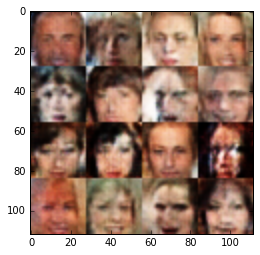

Epoch 0/1... Discriminator Loss: 1.0219... Generator Loss: 0.7385
Epoch 0/1... Discriminator Loss: 0.9028... Generator Loss: 1.0868
Epoch 0/1... Discriminator Loss: 0.7607... Generator Loss: 1.0571
Epoch 0/1... Discriminator Loss: 0.9888... Generator Loss: 0.8038
Epoch 0/1... Discriminator Loss: 0.8680... Generator Loss: 1.0600


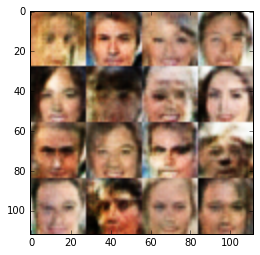

Epoch 0/1... Discriminator Loss: 1.1692... Generator Loss: 1.1900
Epoch 0/1... Discriminator Loss: 1.1562... Generator Loss: 1.1194
Epoch 0/1... Discriminator Loss: 1.2380... Generator Loss: 1.3121
Epoch 0/1... Discriminator Loss: 1.0585... Generator Loss: 0.8162
Epoch 0/1... Discriminator Loss: 1.2915... Generator Loss: 1.1312


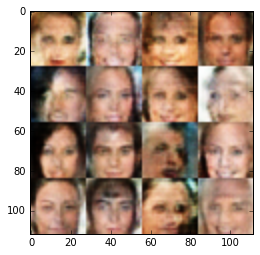

Epoch 0/1... Discriminator Loss: 0.8905... Generator Loss: 0.9408
Epoch 0/1... Discriminator Loss: 0.9394... Generator Loss: 0.7848
Epoch 0/1... Discriminator Loss: 0.9955... Generator Loss: 1.4992
Epoch 0/1... Discriminator Loss: 1.2088... Generator Loss: 1.7084
Epoch 0/1... Discriminator Loss: 0.9409... Generator Loss: 1.1991


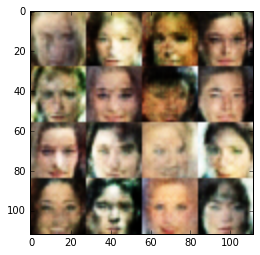

Epoch 0/1... Discriminator Loss: 1.3566... Generator Loss: 0.4232
Epoch 0/1... Discriminator Loss: 1.1420... Generator Loss: 1.4408
Epoch 0/1... Discriminator Loss: 1.1804... Generator Loss: 0.5622
Epoch 0/1... Discriminator Loss: 1.0973... Generator Loss: 0.7794
Epoch 0/1... Discriminator Loss: 1.2364... Generator Loss: 0.5077


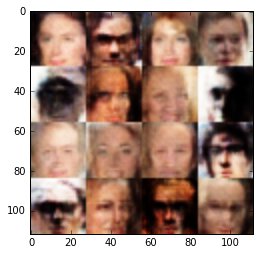

Epoch 0/1... Discriminator Loss: 0.7686... Generator Loss: 1.6819
Epoch 0/1... Discriminator Loss: 0.8873... Generator Loss: 1.0368
Epoch 0/1... Discriminator Loss: 0.9494... Generator Loss: 0.8946
Epoch 0/1... Discriminator Loss: 0.6690... Generator Loss: 1.4908
Epoch 0/1... Discriminator Loss: 0.8624... Generator Loss: 1.4907


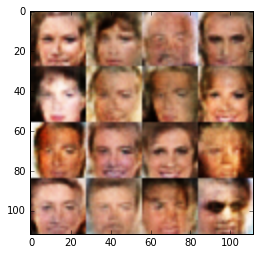

Epoch 0/1... Discriminator Loss: 1.1187... Generator Loss: 1.2041
Epoch 0/1... Discriminator Loss: 1.0509... Generator Loss: 0.7953
Epoch 0/1... Discriminator Loss: 1.1999... Generator Loss: 1.7591
Epoch 0/1... Discriminator Loss: 0.9155... Generator Loss: 1.2046
Epoch 0/1... Discriminator Loss: 1.1238... Generator Loss: 2.0094


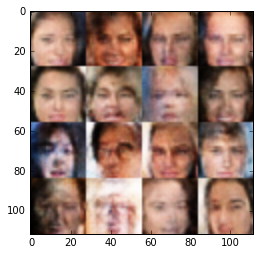

Epoch 0/1... Discriminator Loss: 0.9467... Generator Loss: 0.8627
Epoch 0/1... Discriminator Loss: 0.9325... Generator Loss: 1.0377
Epoch 0/1... Discriminator Loss: 1.0323... Generator Loss: 0.8001
Epoch 0/1... Discriminator Loss: 1.1062... Generator Loss: 0.9524
Epoch 0/1... Discriminator Loss: 1.1015... Generator Loss: 1.6380


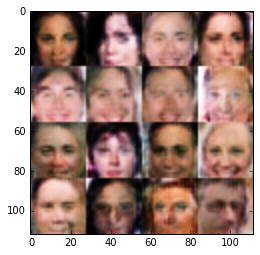

Epoch 0/1... Discriminator Loss: 0.9609... Generator Loss: 0.7816
Epoch 0/1... Discriminator Loss: 0.7101... Generator Loss: 1.1870


In [95]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.